# Домашнее задание № 5

Сегодня мы будем  своими руками реализовывать градиентный бустинг на основе вычисления Lambda!

В качестве базового алгоритма для бустинга будем использовать ```DecisionTreeRegressor``` из библиотеки ```sklearn```. Как было сказано в лекции, единственное существенное отличие — это целевые метки, на которые обучается каждое дерево: вместо типичных для бустинга ошибок (невязок) используются Lambda-значения. Функцию вычисления лямбд мы рассмотрели на практическом занятии. В решение необходимо осмысленно перенести реализацию в метод ```_compute_lambdas``` класса ```Solution```.

## Параметры класса
```n_estimators``` — количество деревьев, которые будут строиться в рамках бустинга.

```lr``` — Learning Rate, коэффициент, на который умножаются предсказания каждого нового дерева в алгоритме (каждое дерево учится предсказывать значение lambda, но не факт, что добавление к текущим предсказаниям такого значения даст оптимум, поэтому весь “путь” оптимизации разбивается на маленькие шаги).

```subsample``` — доля объектов от выборки, на которых обучается каждое дерево (доля одинакова для всех деревьев, но сама подвыборка генерируется на каждом шаге отдельно).

```colsample_bytree``` — доля признаков от выборки, на которых обучается каждое дерево (доля одинакова для всех деревьев, но сама подвыборка генерируется на каждом шаге отдельно).

Совокупность двух вышеуказанных параметров позволяет реализовать метод случайных подпространств (смотрите описание по ссылке при необходимости). ✅🚸🚸 Понятно, что для применения деревьев (получения предсказания) нужно хранить индексы использованных признаков (но не объектов).

```max_depth``` и ```min_samples_leaf``` — параметры ```DecisionTreeRegressor```, отвечающие за глубину построения дерева и минимальное количество в терминальных (финальных) листьях дерева соответственно.

## Методы класса
```_get_data```, ```_prepare_data```, ```_scale_features_in_query_groups```, ```_ndcg_k``` уже знакомы — можно перенести их реализацию  с тем лишь отличием, что для удобства срезов по индексам размерности ```ys_train``` и ```ys_test``` должны быть 💢N∗1, где N-количество объектов (без этого грейдер будет отчитываться об ошибке).

```save_model``` и ```load_model``` — методы, отвечающие за сохранение и загрузку модели. Вам необходимо самостоятельно определить набор полей (их минимум 3), которые нужно сохранять после тренировки и загружать для предсказания. После ```load_model``` необходимо добиться, чтобы модель могла давать те же самые предсказания, что и до сохранения. Сохранение и загрузку реализуйте через модуль ```pickle```. Пример:

```bash
state = {…}
f = open(path, 'wb')
pickle.dump(state, f)
```

Предсказания формируются в методе ```predict```. На вход поступает тензор данных размерности N∗D, где N — количество объектов, D — количество признаков. На выходе ожидается применённый алгоритм бустинга, т.е. тензор предсказаний.

Расчёт метрики по набору данных должен производиться методом ```_calc_data_ndcg``` — в нём необходимо проитерироваться по группам запросов, посчитав в каждой ```NDCG```, после чего вернуть усреднённое значение метрики.

## Методы для тренировки
```_train_one_tree``` — метод для тренировки одного дерева. Принимает на вход ```cur_tree_idx``` — номер текущего дерева, ✅который предлагается использовать в качестве random_seed для того, чтобы алгоритм был детерминирован. ```train_preds``` — суммарные предсказания всех предыдущих деревьев (для расчёта лямбд). В рамках метода необходимо рассчитать лямбды для каждой группы в тренировочном наборе данных, затем применить метод случайных подпространств, сделав срез по признакам (случайно выбранная группа, размер которой задан параметром ```colsample_bytree```) и по объектам (тоже случайно выбранная группа, размер зависит от параметра subsample). Затем произвести тренировку одного ```DecisionTreeRegressor```. Возвращаемые значения — это само дерево и индексы признаков, на которых обучалось дерево.

```fit``` — генеральный метод обучения K деревьев, каждое из которых тренируется с использованием метода ```_train_one_tree```. Изначальные предсказания до обучения предлагается приравнять к нулю и от этих значений отталкиваться при обучении первого дерева. Все обученные деревья необходимо сохранить в список, хранящийся в атрибуте trees класса ```Solution```. 💢Для простоты и ускорения работы предлагается рассчитывать предсказания для всех тренировочных и валидационных данных после обучения каждого дерева (но досчитывать только изменения за последнее дерево, храня в памяти предсказания всех предыдущих). Следите за лучшим значением ```NDCG``` (хранить в переменной ```best_ndcg```) — после окончания тренировки нужно обрезать те последние N деревьев, которые лишь ухудшают метрику на валидации. Например, вы обучили 100 деревьев, и лучший результат был достигнут на 78-м. Тогда ```self.trees``` нужно обрезать до 78-го дерева, чтобы модель при предсказании работала лучше всего.

## Критерии оценки
- Корректная предобработка данных.
- Модель адекватно отработала на 1 дереве, ```NDCG``` выше порога случайных предсказаний.
- Модель на 100 деревьев на подложенных данных обучается, ```NDCG≥0.425```.
- Обученная и сохраненная модель после загрузки корректно дала предсказания в методе ```predict```.

## Utils

In [42]:
import math
from typing import List, Optional, Union

import torch


def num_swapped_pairs(ys_true: torch.Tensor, ys_pred: torch.Tensor) -> int:
    ys_pred_sorted, argsort = torch.sort(ys_pred, descending=True, dim=0)
    ys_true_sorted = ys_true[argsort]

    num_objects = ys_true_sorted.shape[0]
    swapped_cnt = 0
    for cur_obj in range(num_objects - 1):
        for next_obj in range(cur_obj + 1, num_objects):
            if ys_true_sorted[cur_obj] < ys_true_sorted[next_obj]:
                if ys_pred_sorted[cur_obj] > ys_pred_sorted[next_obj]:
                    swapped_cnt += 1
            elif ys_true_sorted[cur_obj] > ys_true_sorted[next_obj]:
                if ys_pred_sorted[cur_obj] < ys_pred_sorted[next_obj]:
                    swapped_cnt += 1
    return swapped_cnt


def compute_gain(y_value: float, gain_scheme: str) -> float:
    if gain_scheme == "exp2":
        gain = 2 ** y_value - 1
    elif gain_scheme == "const":
        gain = y_value
    else:
        raise ValueError(f"{gain_scheme} method not supported, only exp2 and const.")
    return float(gain)


def dcg(ys_true: torch.Tensor, ys_pred: torch.Tensor, gain_scheme: str) -> float:
    _, argsort = torch.sort(ys_pred, descending=True, dim=0)
    ys_true_sorted = ys_true[argsort]
    ret = 0
    for idx, cur_y in enumerate(ys_true_sorted, 1):
        gain = compute_gain(cur_y, gain_scheme)
        ret += gain / math.log2(idx + 1)
    return ret


def ndcg(ys_true: torch.Tensor, ys_pred: torch.Tensor, gain_scheme: str = 'const') -> float:
    pred_dcg = dcg(ys_true, ys_pred, gain_scheme)
    ideal_dcg = dcg(ys_true, ys_true, gain_scheme)

    ndcg = pred_dcg / ideal_dcg
    return ndcg


def precission_at_k(ys_true: torch.Tensor, ys_pred: torch.Tensor, k: int) -> float:
    if ys_true.sum() == 0:
        return -1
    _, argsort = torch.sort(ys_pred, descending=True, dim=0)
    ys_true_sorted = ys_true[argsort]
    hits = ys_true_sorted[:k].sum()
    prec = hits / min(ys_true.sum(), k)
    return float(prec)


def reciprocal_rank(ys_true: torch.Tensor, ys_pred: torch.Tensor) -> float:
    _, argsort = torch.sort(ys_pred, descending=True, dim=0)
    ys_true_sorted = ys_true[argsort]

    for idx, cur_y in enumerate(ys_true_sorted, 1):
        if cur_y == 1:
            return 1 / idx
    return 0


def p_found(ys_true: torch.Tensor, ys_pred: torch.Tensor, p_break: float = 0.15 ) -> float:
    p_look = 1
    p_found = 0
    _, argsort = torch.sort(ys_pred, descending=True, dim=0)
    ys_true_sorted = ys_true[argsort]

    for cur_y in ys_true_sorted:
        p_found += p_look * float(cur_y)
        p_look = p_look * (1 - float(cur_y)) * (1 - p_break)

    return p_found


def average_precision(ys_true: torch.Tensor, ys_pred: torch.Tensor) -> float:
    if ys_true.sum() == 0:
        return -1
    _, argsort = torch.sort(ys_pred, descending=True, dim=0)
    ys_true_sorted = ys_true[argsort]
    rolling_sum = 0
    num_correct_ans = 0

    for idx, cur_y in enumerate(ys_true_sorted, start=1):
        if cur_y == 1:
            num_correct_ans += 1
            rolling_sum += num_correct_ans / idx
    if num_correct_ans == 0:
        return 0
    else:
        return rolling_sum / num_correct_ans

 ## imports/seed


In [43]:
# !pip install catboost

In [110]:
import math
import pickle
import random
from typing import List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from catboost.datasets import msrank_10k
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from tqdm.auto import tqdm


def set_seed(seed: int) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

## Model

In [122]:
class Solution:
    def __init__(self, n_estimators: int = 100, lr: float = 0.5, ndcg_top_k: int = 10,
                 subsample: float = 0.6, colsample_bytree: float = 0.9,
                 max_depth: int = 5, min_samples_leaf: int = 8):
        self.X_train, self.df_X_train = None, None
        self.ys_train, self.df_ys_train = None, None
        self.X_test, self.df_X_test = None, None
        self.ys_test, self.df_ys_test = None, None

        self._prepare_data()

        self.ndcg_top_k = ndcg_top_k
        self.n_estimators = n_estimators  # количество деревьев
        self.lr = lr  # Learning Rate, коэффициент, на который умножаются предсказания каждого нового дерева
        self.max_depth = max_depth  # максимальная глубина
        self.min_samples_leaf = min_samples_leaf  # минимальное количество термальных листьев

        self.subsample = subsample  # доля объектов от выборки
        self.colsample_bytree = colsample_bytree  # доля признаков от выборки

        self.trees: List[DecisionTreeRegressor] = []  # все деревья
        self.featurres_idxs = []
        self.all_ndcg: List[float] = []
        self.best_ndcg = float(0.0)
        self.best_num_trees = 1

        self.train_predicts = torch.zeros(self.ys_train.shape[0], dtype=float).view(-1,1)
        self.test_predicts = torch.zeros(self.ys_test.shape[0], dtype=float).view(-1,1)


    def _get_data(self) -> List[np.ndarray]:
        train_df, test_df = msrank_10k()

        X_train = train_df.drop([0, 1], axis=1).values
        y_train = train_df[0].values
        query_ids_train = train_df[1].values.astype(int)

        X_test = test_df.drop([0, 1], axis=1).values
        y_test = test_df[0].values
        query_ids_test = test_df[1].values.astype(int)

        return [X_train, y_train, query_ids_train, X_test, y_test, query_ids_test]

    def _prepare_data(self) -> None:
        (X_train, y_train, self.query_ids_train,
            X_test, y_test, self.query_ids_test) = self._get_data()
        # допишите ваш код здесь
        self.X_train = torch.FloatTensor(self._scale_features_in_query_groups(X_train, self.query_ids_train))
        self.ys_train = torch.FloatTensor(y_train).view(-1,1)

        self.X_test = torch.FloatTensor(self._scale_features_in_query_groups(X_test, self.query_ids_test))
        self.ys_test = torch.FloatTensor(y_test).view(-1,1)

        self.df_X_train = pd.DataFrame(self.X_train)
        self.df_ys_train = pd.DataFrame(self.ys_train)
        self.df_X_test = pd.DataFrame(self.X_test)
        self.df_ys_test = pd.DataFrame(self.ys_test)

    def _scale_features_in_query_groups(self, inp_feat_array: np.ndarray, inp_query_ids: np.ndarray) -> np.ndarray:
        # допишите ваш код здесь
        for id in np.unique(inp_query_ids):
            scaler = StandardScaler()
            idxs = inp_query_ids == id
            inp_feat_array[idxs] = scaler.fit_transform(inp_feat_array[idxs])

        return inp_feat_array

    def _train_one_tree(self, cur_tree_idx: int,
                        train_preds: torch.FloatTensor
                        ) -> Tuple[DecisionTreeRegressor, np.ndarray]:
        """
        Метод для тренировки одного дерева.

        @cur_tree_idx: номер текущего дерева, который предлагается использовать в качестве random_seed для того,
        чтобы алгоритм был детерминирован.
        @train_preds: суммарные предсказания всех предыдущих деревьев (для расчёта лямбд).
        @return: это само дерево и индексы признаков, на которых обучалось дерево
        """
        # допишите ваш код
        set_seed(cur_tree_idx)
        target = torch.zeros(self.ys_train.shape[0], dtype=float).view(-1,1)

        for id in np.unique(self.query_ids_train):
            idxs = self.query_ids_train == id
            # print(np.sum(idxs))
            # Находим лямбда, на которые будем обучать дерево
            _, _, _, _, lambdas = self._compute_lambdas(self.ys_train[idxs], self.train_predicts[idxs])
            target[idxs] -= lambdas

        # подвыборка фичей
        n_fea = self.df_X_train.shape[1]
        num_to_choice = int(n_fea * self.colsample_bytree)
        features_subsample_idx = np.random.choice(self.df_X_train.columns, num_to_choice, replace=False)
        d3_X_train = self.df_X_train[features_subsample_idx]

        # подвыборка строк выборки
        n_rows = self.df_X_train.shape[0]
        num_to_choice = int(n_rows * self.subsample)
        rows_subsample_idx = np.random.choice(self.df_X_train.index, num_to_choice, replace=False)
        X_train = d3_X_train.iloc[rows_subsample_idx]
        target = pd.DataFrame(target)
        y_train = target.iloc[rows_subsample_idx]

        return DecisionTreeRegressor(max_depth=self.max_depth,
                                     min_samples_leaf=self.min_samples_leaf,
                                     random_state=cur_tree_idx).fit(X_train, y_train), features_subsample_idx


    # def _calc_data_ndcg(self, queries_list: np.ndarray, true_labels: torch.FloatTensor,
    #                     preds: torch.FloatTensor) -> float:
    def _calc_data_ndcg(self, tree_features_subsample_idx) -> float:
        """ Расчёт метрики по набору данных """
        # допишите ваш код здесь
        ndcgs = []
        x_fea_subsample = self.df_X_train[tree_features_subsample_idx]

        for id in np.unique(self.query_ids_test):
            idxs = self.query_ids_test == id
            ys = self.ys_test[idxs]
            x = x_fea_subsample[idxs]

            #  current tree predict
            preds = torch.tensor(self.trees[-1].predict(x), dtype=float)
            self.test_predicts[idxs] += self.lr * preds.view(-1, 1)

            score = self._ndcg_k(ys.squeeze(), self.test_predicts[idxs].squeeze(), self.ndcg_top_k)
            ndcgs.append(score)

        # print("test_ndcg: ", np.mean(ndcgs))
        return np.mean(ndcgs)

    def _calc_data_ndcg_train(self) -> float:
        """ Расчёт метрики по набору данных """
        # допишите ваш код здесь
        ndcgs = []

        for id in np.unique(self.query_ids_train):
            idxs = self.query_ids_train == id

            score = self._ndcg_k(self.ys_train[idxs].squeeze(), self.train_predicts[idxs].squeeze(), self.ndcg_top_k)
            ndcgs.append(score)

        # print("train_ndcg: ", np.mean(ndcgs))
        return np.mean(ndcgs)

    def fit(self):
        """
        генеральный метод обучения K деревьев, каждое из которых тренируется
        с использованием метода _train_one_tree
        """
        set_seed(0)
        train_ndcg = []
        # допишите ваш код здесь

        for i in tqdm(range(self.n_estimators)):
            current_tree, features_subsample_idx = self._train_one_tree(i, self.train_predicts)
            self.trees.append(current_tree)
            self.featurres_idxs.append(features_subsample_idx)

            train_pred = torch.tensor(current_tree.predict(self.df_X_train[features_subsample_idx]), dtype=float).view(-1, 1)
            self.train_predicts += self.lr * train_pred
            train_ndcg.append(self._calc_data_ndcg_train())

            # validation
            current_ndcg = self._calc_data_ndcg(features_subsample_idx)
            self.all_ndcg.append(current_ndcg)
            if current_ndcg > self.best_ndcg:
                self.best_ndcg = current_ndcg
                self.best_num_trees = i+1

        plt.plot(np.arange(self.n_estimators), self.all_ndcg, label='test')
        plt.plot(np.arange(self.n_estimators), train_ndcg, label='train')
        plt.legend()
        print("best ndcg on test:", self.best_ndcg)
        print("optimal number of trees with best ndcg:", self.best_num_trees)
        return self


    # def predict(self, data: torch.FloatTensor) -> torch.FloatTensor:
    #     predict = torch.zeros(self.ys_train.shape[0], dtype=float).view(-1,1)
    #     for i in range(self.best_num_trees):
    #         predict += torch.tensor(self.trees[i].predict(data[self.featurres_idxs[i]]), dtype=float).view(-1, 1)

    #     return predict.squeeze()


#--------------------------------------------------------------------------------------------------------------------------------
    def _compute_lambdas(self, y_true: torch.FloatTensor, y_pred: torch.FloatTensor, ndcg_scheme='exp2') -> torch.FloatTensor:
        # допишите ваш код здесь
        # рассчитаем нормировку, IdealDCG
        ideal_dcg = dcg(y_true, y_true, ndcg_scheme)
        N = 1 / (ideal_dcg + 1e-10)

        # рассчитаем порядок документов согласно оценкам релевантности
        _, rank_order = torch.sort(y_true, descending=True, axis=0)
        rank_order += 1

        with torch.no_grad():
            # получаем все попарные разницы скоров в батче
            pos_pairs_score_diff = 1.0 + torch.exp((y_pred - y_pred.t()))

            # поставим разметку для пар, 1 если первый документ релевантнее
            # -1 если второй документ релевантнее
            Sij = self._compute_labels_in_batch(y_true)
            # посчитаем изменение gain из-за перестановок
            gain_diff = self._compute_gain_diff(y_true, ndcg_scheme)

            # посчитаем изменение знаменателей-дискаунтеров
            decay_diff = (1.0 / torch.log2(rank_order + 1.0)) - (1.0 / torch.log2(rank_order.t() + 1.0))
            # посчитаем непосредственное изменение nDCG
            delta_ndcg = torch.abs(N * gain_diff * decay_diff)
            # посчитаем лямбды
            lambda_update =  (0.5 * (1 - Sij) - 1 / pos_pairs_score_diff) * delta_ndcg
            lambda_update = torch.sum(lambda_update, dim=1, keepdim=True)

            return Sij, gain_diff, decay_diff, delta_ndcg, lambda_update

    def _compute_labels_in_batch(self, y_true):

        # разница релевантностей каждого с каждым объектом
        rel_diff = y_true - y_true.t()

        # 1 в этой матрице - объект более релевантен
        pos_pairs = (rel_diff > 0).type(torch.float32)

        # 1 тут - объект менее релевантен
        neg_pairs = (rel_diff < 0).type(torch.float32)
        Sij = pos_pairs - neg_pairs
        return Sij

    def _compute_gain_diff(self, y_true, gain_scheme):
        if gain_scheme == "exp2":
            gain_diff = torch.pow(2.0, y_true) - torch.pow(2.0, y_true.t())
        elif gain_scheme == "diff":
            gain_diff = y_true - y_true.t()
        else:
            raise ValueError(f"{gain_scheme} method not supported")
        return gain_diff
#--------------------------------------------------------------------------------------------------------------------------------

    def _ndcg_k(self, ys_true, ys_pred, ndcg_top_k) -> float:
        # допишите ваш код здесь
        try:
            return ndcg(ys_true[:ndcg_top_k], ys_pred[:ndcg_top_k])
        except ZeroDivisionError:
            return float(0)

    def save_model(self, path: str):
        # допишите ваш код здесь
        pass

    def load_model(self, path: str):
        # допишите ваш код здесь
        pass




  0%|          | 0/100 [00:00<?, ?it/s]

best ndcg on test: 0.5969160491606288
optimal number of trees with best ndcg: 71


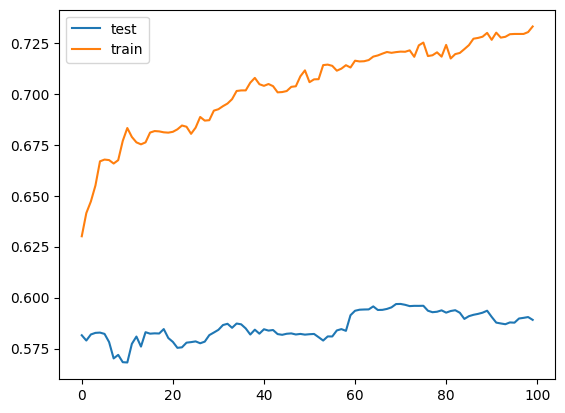

In [123]:
sol = Solution()
sol.fit()


# Запуск и сохранение модели

In [ ]:
from hw6_solved import Solution

In [ ]:
sol = Solution()
sol.fit()
sol.load_model("model.pckl")

In [ ]:
sol = Solution()
sol.fit()
sol.load_model("model.pckl")

  0%|          | 0/200 [00:00<?, ?it/s]

best test ndcg: 0.433 (179)
